# Real-time adaptive threshold detection for crisis monitoring

### The code for Adaptive Threshold Detection (ATD) using normally distributed samples is in the Supplementary information. 
### This code was built in a Python 3.11.5 environment utilizing Anaconda Jupyter notebook.

In [1]:
from scipy.signal import savgol_filter  # 1.11.1
import numpy as np  # v.1.24.3
import pandas as pd  # 2.0.3
import matplotlib.pyplot as plt  # v.3.7.2

## Step 1: Data preparation

#### Extract random data from a standard normal distribution. True threshold is assumed, and data exceeding it is designated as observed extreme values.

2.8705007693411506 3.0788808084552377 2


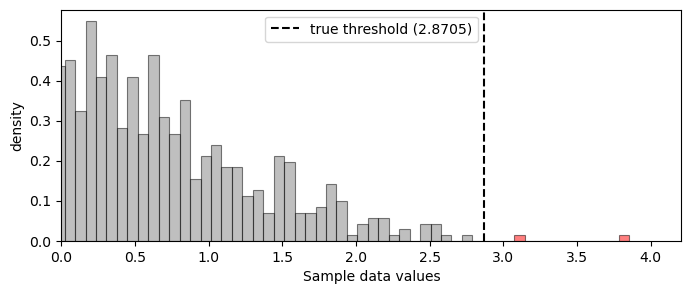

In [62]:
np.random.seed(42)
sample_size = 1000
num_extreme = 2
data = np.random.normal(0, 1, sample_size)

np.random.seed(1)
true_threshold = np.random.uniform(np.percentile(data, 100-(num_extreme/sample_size*100)), np.percentile(data, 100-(1/sample_size*100)))

T_sev = np.min(data[data > true_threshold])
print(true_threshold, T_sev, len(data[data>true_threshold]))

plt.figure(figsize=(8,3))
n, bins, patches = plt.hist(data, bins=100,color = 'grey', alpha=0.5, edgecolor = 'black' ,linewidth = 0.8, density=True)
for i in range(len(patches)-len(bins[bins>=T_sev]), len(patches)): 
    patches[i].set_facecolor('red')
plt.axvline(true_threshold, color='black', label = 'true threshold (2.8705)', linestyle='--')
plt.xlim(0,)
plt.xlabel('Sample data values')
plt.ylabel('density')
plt.legend()
# plt.savefig('sample_data.png', dpi=600, bbox_inches="tight")

## Step 2: Adaptive Sampling

#### Extract two random pieces of data from the entire data. If their mean is greater than or equal to the smallest observed extreme value (T_sev), they become potential extreme values. As this process is repeated, the number of candidates for potential extreme values increases.
#### In sufficiently collected samples, only the portion smaller than T_sev is designated as the threshold candidate range. This is because parts larger than T_sev have already been classified as extreme values. The purpose of adaptive sampling is to extract extreme value candidates from a range smaller than T_sev, reduce noise in the data, and precisely perform the next step, hill estimate.

In [50]:
adaptive_samples = []
subset_size = 2

data = np.sort(data)[::-1]
extreme_events = data[data >= T_sev]
potential_range = data[data >= T_sev-(extreme_events[0]-T_sev)]

for i in range(0, len(extreme_events)):
    for j in range(i+1, len(potential_range)-i):
        if (potential_range[i]+potential_range[i+j])/2 >= T_sev:
            adaptive_samples.append(potential_range[i])
            adaptive_samples.append(potential_range[i+j])                
            adaptive_samples.append((potential_range[i]+potential_range[i+j])/2)
adaptive_samples = np.array(adaptive_samples)
threshold_candidate_range = adaptive_samples[adaptive_samples < T_sev]            

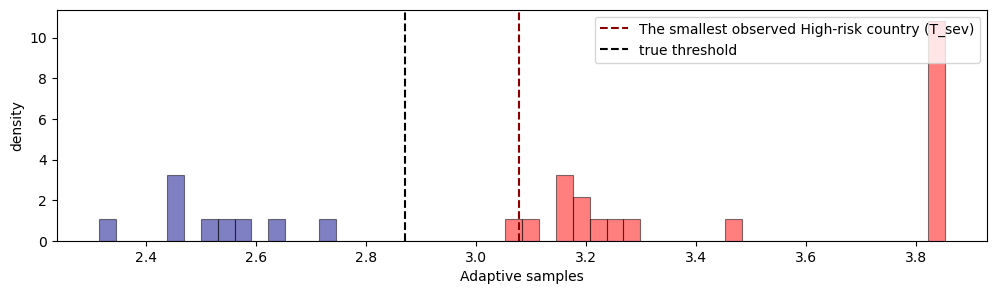

In [51]:
plt.figure(figsize=(12,3))
n, bins, patches = plt.hist(adaptive_samples, bins=50,color = 'darkblue', alpha=0.5, density=True,edgecolor = 'black' ,linewidth = 0.8)
for i in range(len(patches)-len(bins[bins>=T_sev]), len(patches)): 
    patches[i].set_facecolor('red')
plt.axvline(T_sev, linestyle='--', color = 'darkred', label = 'The smallest observed High-risk country (T_sev)')
plt.axvline(true_threshold, color='black', label = 'true threshold', linestyle='--')
plt.xlabel('Adaptive samples')
plt.ylabel('density')
plt.legend()

## Step 3: Hill estimation

#### The Hill estimator was then applied to the retained samples identified in Step 2. This estimator quantifies the heaviness of the distribution’s tail by considering both the spacing and frequency of the data.
#### According to the Pickands – Balkema - de Haan theorem, the tail of a distribution converges to a Generalized Pareto Distribution (GPD), regardless of the shape of the parent distribution. This implies that a transition point exists where tail behavior shifts, marking a change in heaviness.

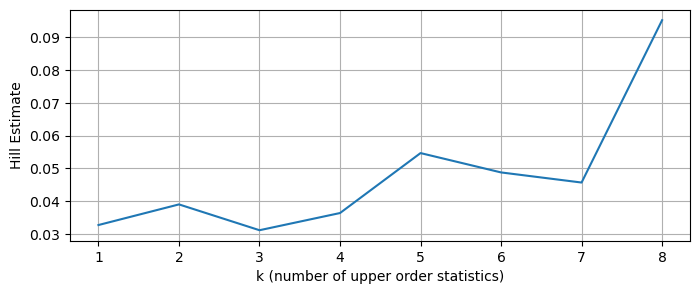

In [52]:
threshold_candidate_range = np.sort(threshold_candidate_range)[::-1]  # Sort Data in Descending Order
        
k_values = np.arange(1, len(threshold_candidate_range))  # k order statistics
hill_estimates = np.array([np.mean(np.log(threshold_candidate_range[:k]) - 
                                   np.log(threshold_candidate_range[k])) for k in k_values])

plt.figure(figsize=(8,3))
plt.plot(k_values, hill_estimates)
plt.xlabel('k (number of upper order statistics)')
plt.ylabel('Hill Estimate')
plt.grid(True)

## Step 4: Savitzky-Golay Filtering and Inflection Point Detection

#### When there is a sufficient amount of observed extreme value data, the threshold estimated in Step 3 is generally reliable.  A sufficient amount refers to 5 or more observed extreme values experimentally. 
#### However, in cases with limited data, Step 4 applies a smoothing process to correct for potential irregularities and biases in the Hill estimator. To improve the accuracy of the Hill estimator and reduce the effects of sampling noise, Savitzky-Golay filtering is employed. This smoothing technique minimizes noise while preserving critical structural characteristics, such as inflection points, which are essential for identifying shifts in the tail behavior of the distribution.
#### Finally, ATD designates the first inflection point of the second-differentiated hill estimator as the threshold.

True Threshold: 2.8705007693411506
Estimated Threshold: 2.826120305852549
Error: 0.044380463488601585


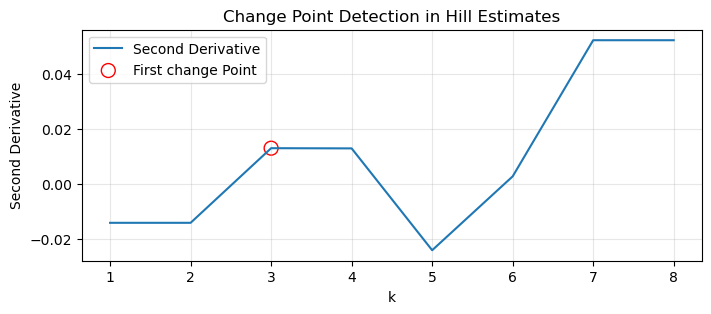

In [64]:
poly_order = 2
window = 3
second_derivative = savgol_filter(hill_estimates, window_length=window, polyorder=2, deriv=2)

# Detect Change Points
change_points = []
for i in range(1, len(second_derivative)-1):
    if (second_derivative[i] - second_derivative[i-1] < 0 and second_derivative[i+1] - second_derivative[i] > 0) or \
       (second_derivative[i] - second_derivative[i-1] > 0 and second_derivative[i+1] - second_derivative[i] < 0):
        change_points.append(i)

# Select First Detected Change Point as the Estimated Threshold
if change_points:
    loc = change_points[0]
    threshold_estimate = threshold_candidate_range[loc]
else:
    loc = None
    threshold_estimate = None

# If the number of observed extreme values ​​is small, correction can be made to reduce sampling bias (option).    
if len(data[data>true_threshold]) < 5:
    ATD_threshold = (T_sev+threshold_estimate)/2
else:
    ATD_threshold = threshold_estimate

print(f"True Threshold: {true_threshold}")
print(f"Estimated Threshold: {ATD_threshold}")
print(f"Error: {abs((T_sev+threshold_estimate)/2 - true_threshold)}")


plt.figure(figsize=(8, 3))
plt.grid(alpha=0.3)
plt.plot(k_values, second_derivative, label='Second Derivative')
if loc is not None:
    plt.scatter(k_values[loc], second_derivative[loc], s=100, facecolors='none', edgecolors='r', label='First change Point')
plt.legend()
plt.xlabel('k')
plt.ylabel('Second Derivative')
plt.title('Change Point Detection in Hill Estimates')
plt.show()


# Traditional method: Visual threshold estimation using Hill plot

#### Data and true threshold are the same

if k=8 : 2.463242112485286
if k=18: 2.1439440893253257


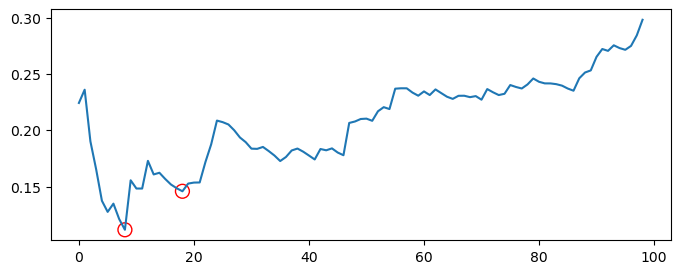

In [97]:
hill_estimates = []
max_k=100

data_sorted = np.sort(data)[-max_k:]  # Extract top k extreme values
log_data = np.log(data_sorted)
for k in range(1, max_k):
    hill_estimates.append(np.mean(log_data[-k:]) - log_data[-k-1])

plt.figure(figsize=(8, 3))
plt.plot(hill_estimates)   
plt.scatter(8, hill_estimates[8], s=100, facecolor='none', edgecolor='red',linewidth=1)
plt.scatter(18, hill_estimates[18], s=100, facecolor='none', edgecolor='red',linewidth=1)

print('if k=8 :',np.exp(log_data[-8]))
print('if k=18:',np.exp(log_data[-18]))

#### The threshold of a Hill plot is usually chosen as the point at which the slope stabilizes. As shown in the picture above, it is difficult to determine where the slope stabilizes in real data.

# Compare ATD and Hill plot 

Text(0, 0.5, 'density')

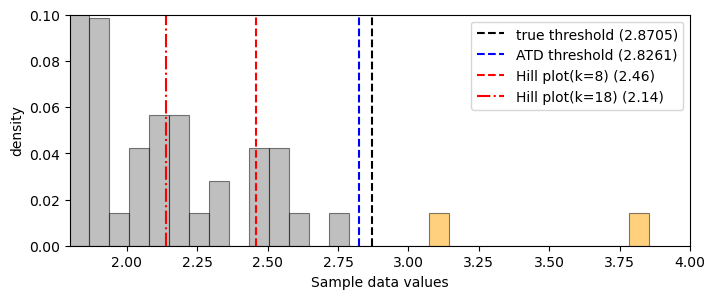

In [100]:
plt.figure(figsize=(8,3))
n, bins, patches = plt.hist(data, density = True,
                            bins=100,color = 'grey', alpha=0.5, edgecolor = 'black' ,linewidth = 0.8)
for i in range(len(patches)-len(bins[bins>=T_sev]), len(patches)): 
    patches[i].set_facecolor('orange')
    
plt.axvline(true_threshold, color='black', linestyle='--', label = f'true threshold ({np.round(true_threshold,4)})')
plt.axvline(ATD_threshold, color = 'blue', linestyle = '--', label=f'ATD threshold ({np.round(ATD_threshold,4)})')
plt.axvline(2.46, color = 'red', linestyle = '--', label=f'Hill plot(k=8) ({2.46})')
plt.axvline(2.14, color = 'red', linestyle = '-.', label=f'Hill plot(k=18) ({2.14})')

plt.xlim(1.8, 4)
plt.ylim(0, 0.1)
plt.legend()
plt.xlabel('Sample data values')
plt.ylabel('density')